# Imports

In [70]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np

from histomicstk.preprocessing.color_normalization import deconvolution_based_normalization
from histomicstk.saliency.tissue_detection import (
    get_slide_thumbnail, get_tissue_mask)
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from stardist.models import StarDist2D
from stardist.plot import render_label

from utils.helpers import compare_two_images, cut_out_image
from tiatoolbox.tools import stainnorm
from typing import List, Tuple

# Setup

In [49]:
image_paths = sorted(["data/images/"+path for path in os.listdir("data/images") if not path.startswith(".")])
images = list(map(tifffile.imread, image_paths))

normalized_image_paths = sorted(["data/normalized_images/"+path for path in os.listdir("data/normalized_images/") if not path.startswith(".")])
normalized_images = list(map(tifffile.imread, normalized_image_paths))

mask_paths = sorted(["data/masks/"+path for path in os.listdir("data/masks") if not path.startswith(".")])
masks = list(map(tifffile.imread, mask_paths))
data = list(zip(images, masks))

# Find Reference Image

In [ ]:
def calculate_histogram_separation(image: np.ndarray, mask: np.ndarray, model: StarDist2D) -> float:
    """Calculate the histogram separation of a given image.

    Args:
        image (np.ndarray): The image to calculate the histogram separation of.
        mask (np.ndarray): The mask to use to extract tissue from the image.
        model (StarDist2D): The model to use for segmentation.

    Returns:
        float: The separation score of the image, calculated as the sum of the absolute differences between the foreground and background histograms.
    """
    
    image_normed = rescale_intensity(image, out_range=(0, 1))
    labels, data_dict = model.predict_instances(image_normed, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)

    nuclei_mask = labels > 0
    tissue_mask = mask & ~nuclei_mask

    nuclei_intensities = image[nuclei_mask]
    tissue_intensities = image[tissue_mask]

    if len(nuclei_intensities) < 100 or len(tissue_intensities) < 100:
        return 0.0

    mean_nuclei = np.mean(nuclei_intensities)
    mean_tissue = np.mean(tissue_intensities)
    std_nuclei = np.std(nuclei_intensities)
    std_tissue = np.std(tissue_intensities)
    
    # Use between-class variance
    w_nuclei = len(nuclei_intensities) / (len(nuclei_intensities) + len(tissue_intensities))
    w_tissue = 1 - w_nuclei
    
    separation_score = w_nuclei * w_tissue * (mean_nuclei - mean_tissue) ** 2
    
    return separation_score


In [58]:
def find_reference_image(data: List[Tuple[np.ndarray, np.ndarray]], model: StarDist2D) -> Tuple[int, np.ndarray]:
    """Finds the reference image with the most separated nuclei and background histograms.

    Args:
        data (List[Tuple[np.ndarray, np.ndarray]]): The images and masks to choose the reference image from.
        model (StarDist2D): The model to use for segmentation.
    Returns:
        Tuple[int, np.ndarray]: A tuple containing the index of the reference image and the reference image array.
    """
    
    print("Analyzing histogram separation for all images...")
    
    max_separation_score = 0
    reference_idx = 0
    reference_image = images[0]
    
    for i, (image, mask) in enumerate(data):
        separation_score = calculate_histogram_separation(image, mask, model)
        if separation_score > max_separation_score:
            max_separation_score = separation_score
            reference_idx = i
            reference_image = image
    
    print(f"\nReference image selected: Image {reference_idx} with score {max_separation_score:.4f}")
    
    return reference_idx, reference_image

In [55]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [59]:
ref_idx, ref_img = find_reference_image(data, model)

Analyzing histogram separation for all images...

Reference image selected: Image 9 with score 634.4435


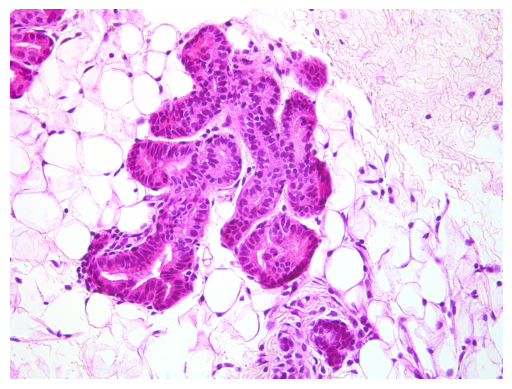

In [63]:
plt.imshow(ref_img)
plt.axis(False)
plt.show()

# Test Macenko and Vahadane Normalization with Reference Image

In [64]:
vah_norm = stainnorm.VahadaneNormalizer()
vah_norm.fit(ref_img)

|2025-11-03|22:02:15.405| [WARNING] Vahadane stain extraction/normalization algorithms are unstable after the update to `dictionary learning` algorithm in scikit-learn > v0.23.0 (see issue #382). Please be advised and consider using other stain extraction (normalization) algorithms.


In [ ]:
mac_norm = stainnorm.MacenkoNormalizer()
mac_norm.fit(ref_img)

In [68]:
# for img in images:
#     img_norm_vah = vah_norm.transform(img.copy())
#     img_norm_mac = mac_norm.transform(img.copy())
#     compare_two_images(img, img_norm_vah, "Original Image", "Vahadane Normalized Image")
#     compare_two_images(img, img_norm_mac, "Original Image", "Macenko Normalized Image")

# Test Macenko Normalization for Segmentation

In [72]:
# for image, mask in data:
#     image_norm = mac_norm.transform(image.copy())
#     image_resc = rescale_intensity(image, out_range=(0, 1))
#     image_norm_resc = rescale_intensity(image_norm, out_range=(0, 1))
#     labels, _ = model.predict_instances(image_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels_norm, _ = model.predict_instances(image_norm_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels = cut_out_image(labels, mask)
#     labels_norm = cut_out_image(labels_norm, mask)
#     compare_two_images(render_label(labels, img=image_resc, cmap=(1.0, 1.0, 0), alpha=0.6), render_label(labels_norm, img=image_norm_resc, cmap=(1.0, 1.0, 0), alpha=0.6))

Macenko normalization does not improve the segmentation quality, in some cases it even reduces the performance. For now, do not apply macenko normalization but continue with the original images.

# Test Reinhard Normalization

In [75]:
reinhard_norm = stainnorm.ReinhardNormalizer()
reinhard_norm.fit(ref_img)

In [77]:
# for img in images:
#     img_norm = reinhard_norm.transform(img.copy())
#     compare_two_images(img, img_norm, "Original Image", "Reinhard Normalized Image")

Reihnard Normalization is overshooting the colors and contrast as well, so continue without normalization.

# --- OLD NORMALIZATION EXPERIMENTS ---

### Test Reference Image 1

In [ ]:
# Only for visualization in presentation

# for i, img in enumerate(images):
#     img_norm_vah = stain_normalizer_2.transform(img.copy())
#     img_norm_mac = normalized_images[i]
#     plt.figure(figsize=(18, 6))

#     plt.subplot(1, 3, 1)
#     plt.axis(False)
#     plt.title("Original Image")
#     plt.imshow(img, cmap='gray')

#     plt.subplot(1, 3, 2)
#     plt.axis(False)
#     plt.title("Macenko Normalized Image")
#     plt.imshow(img_norm_mac)

#     plt.subplot(1, 3, 3)
#     plt.axis(False)
#     plt.title("Vahadane Normalized Image")
#     plt.imshow(img_norm_vah)

#     plt.show()

In [29]:
# for img in images:
#     img_norm = stain_normalizer_1.transform(img.copy())
#     compare_two_images(img, img_norm, "Original Image", "Normalized Image (Ref1)")

##### Compare segmentation performance with non-normalized and Ref1-normalization

In [16]:
from stardist.models import StarDist2D
from stardist.plot import render_label
from skimage.exposure import rescale_intensity

In [13]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [14]:
mask_paths = sorted(["data/masks/"+path for path in os.listdir("data/masks") if not path.startswith(".")])
masks = list(map(tifffile.imread, mask_paths))
data = list(zip(images, masks))

In [30]:
# for image, mask in data:
#     image_norm = stain_normalizer_1.transform(image.copy())
#     image_resc = rescale_intensity(image, out_range=(0, 1))
#     image_norm_resc = rescale_intensity(image_norm, out_range=(0, 1))
#     labels, _ = model.predict_instances(image_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels_norm, _ = model.predict_instances(image_norm_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels = cut_out_image(labels, mask)
#     labels_norm = cut_out_image(labels_norm, mask)
#     compare_two_images(render_label(labels, img=image_resc, cmap=(1.0, 1.0, 0), alpha=0.6), render_label(labels_norm, img=image_norm_resc, cmap=(1.0, 1.0, 0), alpha=0.6))

### Test Reference Image 2

In [32]:
# for img in images:
#     img_norm = stain_normalizer_2.transform(img.copy())
#     compare_two_images(img, img_norm, "Original Image", "Normalized Image (Ref2)")

In [31]:
# for image, mask in data:
#     image_norm = stain_normalizer_2.transform(image.copy())
#     image_resc = rescale_intensity(image, out_range=(0, 1))
#     image_norm_resc = rescale_intensity(image_norm, out_range=(0, 1))
#     labels, _ = model.predict_instances(image_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels_norm, _ = model.predict_instances(image_norm_resc, axes='YXC', prob_thresh=0.05, nms_thresh=0.3, return_labels=True)
#     labels = cut_out_image(labels, mask)
#     labels_norm = cut_out_image(labels_norm, mask)
#     compare_two_images(render_label(labels, img=image_resc, cmap=(1.0, 1.0, 0), alpha=0.6), render_label(labels_norm, img=image_norm_resc, cmap=(1.0, 1.0, 0), alpha=0.6))

In [29]:
def create_mask(img):
    mask_out, _ = get_tissue_mask(
    img, deconvolve_first=True,
    n_thresholding_steps=1, sigma=1.5, min_size=30)

    mask_out_fixed = resize(
    mask_out == 0, output_shape=img.shape[:2],
    order=0, preserve_range=True) == 1

    return ~mask_out_fixed

In [20]:
reference_mask_1 = create_mask(reference_image_1)
reference_mask_2 = create_mask(reference_image_2)

In [38]:
# cut_out_reference_1 = cut_out_image(reference_image_1, reference_mask_1)
# cut_out_reference_2 = cut_out_image(reference_image_2, reference_mask_2)
# compare_two_images(cut_out_reference_1, cut_out_reference_2)

In [22]:
def color_normalization_macenko(target_img, reference_img, mask=None, stains=['hematoxylin', 'eosin'], stain_unmixing_method='macenko_pca'):
    stain_unmixing_routine_params = {
        'stains': stains,
        'stain_unmixing_method': stain_unmixing_method
    }

    normalized_target_img = deconvolution_based_normalization(
            target_img, im_target=reference_img,
            mask_out = mask,
            stain_unmixing_routine_params=stain_unmixing_routine_params,)

    return normalized_target_img

In [32]:
masks = [create_mask(img) for img in images]

In [24]:
# compare_two_images(images[5], masks[5])

### Test Reference Image 1 without cutout

In [79]:
normalized_images_1 = [color_normalization_macenko(image, reference_image_1, masks[i]) for i, image in enumerate(images)]

In [92]:
# for img, norm_img in zip(images, normalized_images_1):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("Original image")
#     plt.imshow(img)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Normalized image")
#     plt.imshow(norm_img)

#     plt.show()

### Test reference image 2 without cutout

In [35]:
normalized_images_2 = [color_normalization_macenko(image, reference_image_2, masks[i]) for i, image in enumerate(images)]

In [37]:
# for img, norm_img in zip(images, normalized_images_2):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("Original image")
#     plt.imshow(img)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Normalized image")
#     plt.imshow(norm_img)

#     plt.show()

### Test reference image 1 with cut out

In [83]:
normalized_images_1_cut = [color_normalization_macenko(image, cut_out_reference_1, masks[i]) for i, image in enumerate(images)]

In [94]:
# for img, norm_img in zip(images, normalized_images_1_cut):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("Original image")
#     plt.imshow(img)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Normalized image")
#     plt.imshow(norm_img)

#     plt.show()

### Test reference 2 with cutout

In [85]:
normalized_images_2_cut = [color_normalization_macenko(image, cut_out_reference_2, masks[i]) for i, image in enumerate(images)]

In [95]:
# for img, norm_img in zip(images, normalized_images_2_cut):
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.axis(False)
#     plt.title("Original image")
#     plt.imshow(img)

#     plt.subplot(1, 2, 2)
#     plt.axis(False)
#     plt.title("Normalized image")
#     plt.imshow(norm_img)

#     plt.show()

Reference image 2 without cutout seems to provide the best results!

In [20]:
test = [[1, 2], [-1, 5]]
test[0]

[1, 2]

In [21]:
test[1]

[-1, 5]

In [22]:
test[:]

[[1, 2], [-1, 5]]

In [ ]:
test[:]

[1, 2]